In [ ]:
! pip install kagglehub

In [ ]:
# Install required libraries


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [ ]:
from pathlib import Path
import os

def count_files_pathlib(directory_path):
    """Counts the number of files in a given directory (non-recursive)."""
    p = Path(directory_path)
    print(p)
    # Use a list comprehension to count only items that are files
    files = [entry for entry in p.iterdir() if entry.is_file()]
    return len(files)

# Example usage:
# The path variable from the previous cell holds the correct dataset download location.
# We need to construct the full path to the image parts.
folder_to_check = os.path.join(path, 'HAM10000_images_part_2') # Corrected path using the 'path' variable
file_count = count_files_pathlib(folder_to_check)
print(f"Number of files: {file_count}")

/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2
Number of files: 5015


In [ ]:
metadata = pd.read_csv(os.path.join(path, "HAM10000_metadata.csv"))
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
len(metadata) #images part1 + part2 (5000+5015)

10015

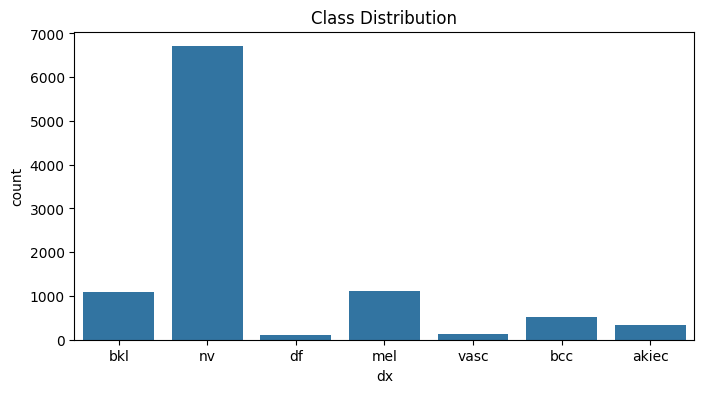

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='dx', data=metadata)
plt.title("Class Distribution")
plt.show()

#Imbalance of classes


In [ ]:
# Paths
dir1 = os.path.join(path, "HAM10000_images_part_1")
dir2 = os.path.join(path, "HAM10000_images_part_2")

image_dirs = [dir1, dir2]
image_paths = {
    os.path.splitext(f)[0]: os.path.join(d, f)
    for d in image_dirs
    for f in os.listdir(d)
}

metadata['path'] = metadata['image_id'].map(image_paths)
metadata = metadata.dropna(subset=['path'])

In [ ]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...


In [ ]:
len(metadata)

10015

In [ ]:
train_df, val_df = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata['dx'],
    random_state=42
)


In [ ]:
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index()
        self.transform = transform
        self.labels = df['dx'].astype('category').cat.codes
        self.classes = df['dx'].astype('category').cat.categories

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = SkinDataset(train_df, transform)
val_dataset = SkinDataset(val_df, transform)

# Use multiple workers for faster data loading and pin_memory for faster GPU transfer
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 161MB/s]


In [ ]:
from tqdm.auto import tqdm

def train_model(model, loader):
    model.train()
    total_loss = 0

    for images, labels in tqdm(loader, desc="Training"): # Added tqdm here
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
for epoch in range(10):
    loss = train_model(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 1, Loss: 0.7547


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 2, Loss: 0.4534


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 3, Loss: 0.2997


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 4, Loss: 0.2034


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 5, Loss: 0.1267


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0984


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0775


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0620


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0542


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0431


In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


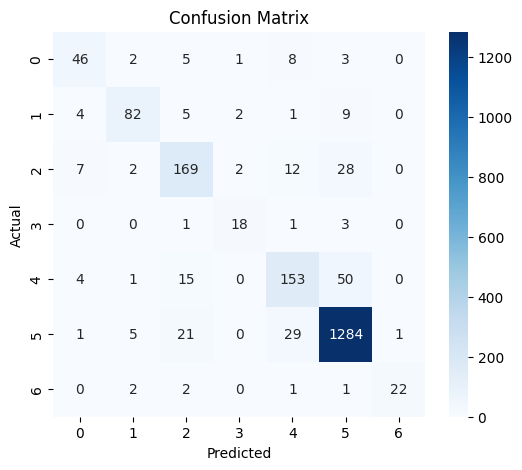

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
class_names = ['akiec','bcc','bkl','df','mel','nv','vasc']

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

       akiec       0.74      0.71      0.72        65
         bcc       0.87      0.80      0.83       103
         bkl       0.78      0.77      0.77       220
          df       0.78      0.78      0.78        23
         mel       0.75      0.69      0.71       223
          nv       0.93      0.96      0.94      1341
        vasc       0.96      0.79      0.86        28

    accuracy                           0.89      2003
   macro avg       0.83      0.78      0.80      2003
weighted avg       0.88      0.89      0.88      2003



In [ ]:
class BrightnessDataset(Dataset):
    def __init__(self, df, brightness_factor, transform=None):
        self.df = df.reset_index()
        self.transform = transform
        self.brightness_factor = brightness_factor
        self.labels = df['dx'].astype('category').cat.codes

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply brightness in numpy
        image = np.clip(image * self.brightness_factor, 0, 255).astype(np.uint8)

        # Now apply normal transform (which includes ToPILImage)
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return image, label


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_brightness(model, df, brightness_factor):
    dataset = BrightnessDataset(df, brightness_factor, transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.numpy())

    acc = accuracy_score(labels_all, preds_all)
    return acc


In [ ]:
brightness_levels = [0.5, 0.7, 1.0, 1.3, 1.5]
results = {}

for b in brightness_levels:
    acc = evaluate_brightness(model, val_df, b)
    results[b] = acc
    print(f"Brightness {b}: Accuracy = {acc:.4f}")


Brightness 0.5: Accuracy = 0.6895
Brightness 0.7: Accuracy = 0.7698
Brightness 1.0: Accuracy = 0.8857
Brightness 1.3: Accuracy = 0.8273
Brightness 1.5: Accuracy = 0.7529


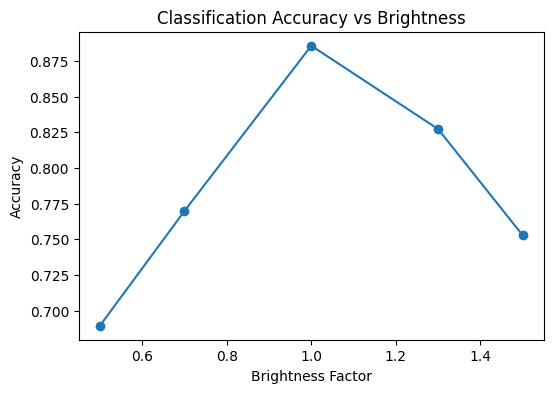

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.xlabel("Brightness Factor")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy vs Brightness")
plt.show()


In [ ]:
# downloading the segmented images and mapping them with nrml ones
# Image: ISIC_xxx.jpg
# Mask:  ISIC_xxx_segmentation.png
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tschandl/ham10000-lesion-segmentations")

print("Path to dataset files:", path)

100%|██████████| 10.3M/10.3M [00:00<00:00, 88.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tschandl/ham10000-lesion-segmentations/versions/1


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
import os

image_dir_1 = dir1
image_dir_2 = dir2
mask_dir = os.path.join(path, 'HAM10000_segmentations_lesion_tschandl')

image_dict = {}

# Part 1
for f in os.listdir(image_dir_1):
    if f.endswith(".jpg"):
        image_id = f.replace(".jpg", "")
        image_dict[image_id] = os.path.join(image_dir_1, f)

# Part 2
for f in os.listdir(image_dir_2):
    if f.endswith(".jpg"):
        image_id = f.replace(".jpg", "")
        image_dict[image_id] = os.path.join(image_dir_2, f)

print("Total images:", len(image_dict))

Total images: 10015


In [ ]:
image_dict

{'ISIC_0028933': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg',
 'ISIC_0028394': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg',
 'ISIC_0027799': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg',
 'ISIC_0028100': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg',
 'ISIC_0027960': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg',
 'ISIC_0028872': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg',
 'ISIC_0026412': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg',
 'ISIC_0024872': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg',
 'ISIC_0026232': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026232.jpg',
 'ISIC_0027031': '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027

In [ ]:
image_paths = []
mask_paths = []

for mask_name in os.listdir(mask_dir):
    if mask_name.endswith(".png"):
        image_id = mask_name.replace("_segmentation.png", "")

        if image_id in image_dict:
            image_paths.append(image_dict[image_id])
            mask_paths.append(os.path.join(mask_dir, mask_name))

print("Matched pairs:", len(image_paths))


Matched pairs: 10015


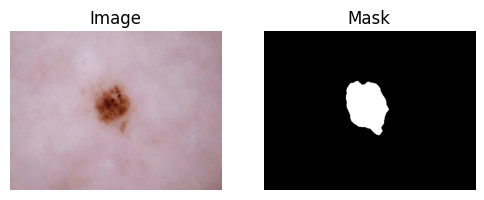

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(image_paths[1000])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_paths[1000], 0)

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()


In [ ]:
  train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths,
    mask_paths,
    test_size=0.2,
    random_state=42
)


In [ ]:
class SegDataset(Dataset):
    def __init__(self, images, masks, brightness=None):
        self.images = images
        self.masks = masks
        self.brightness = brightness

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        img = img / 255.0

        if self.brightness is not None:
            img = np.clip(img * self.brightness, 0, 1)

        mask = cv2.imread(self.masks[idx], 0)
        mask = cv2.resize(mask, (224,224))
        mask = (mask > 0).astype(np.float32)

        img = torch.tensor(img).permute(2,0,1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return img, mask


In [ ]:
train_loader = DataLoader(SegDataset(train_imgs, train_masks),
                          batch_size=16, shuffle=True)

val_loader = DataLoader(SegDataset(val_imgs, val_masks),
                        batch_size=16, shuffle=False)


In [ ]:
bce = nn.BCELoss()

def dice_loss(pred, target, smooth=1):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2*intersection + smooth) /
                (pred.sum() + target.sum() + smooth))

def total_loss(pred, target):
    return 0.5*bce(pred, target) + 0.5*dice_loss(pred, target)


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(3,64)
        self.d2 = DoubleConv(64,128)
        self.d3 = DoubleConv(128,256)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')

        self.u1 = DoubleConv(256+128,128)
        self.u2 = DoubleConv(128+64,64)

        self.out = nn.Conv2d(64,1,1)

    def forward(self,x):
        c1 = self.d1(x)
        c2 = self.d2(self.pool(c1))
        c3 = self.d3(self.pool(c2))

        u1 = self.up(c3)
        u1 = torch.cat([u1,c2], dim=1)
        u1 = self.u1(u1)

        u2 = self.up(u1)
        u2 = torch.cat([u2,c1], dim=1)
        u2 = self.u2(u2)

        return torch.sigmoid(self.out(u2))


In [ ]:
class UNetPlusPlus(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = DoubleConv(3,64)
        self.conv2 = DoubleConv(64,128)
        self.conv3 = DoubleConv(128,256)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')

        self.conv2_1 = DoubleConv(128+256,128)
        self.conv1_2 = DoubleConv(64+128,64)

        self.out = nn.Conv2d(64,1,1)

    def forward(self,x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))

        x2_1 = self.conv2_1(torch.cat([x2, self.up(x3)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1, self.up(x2_1)], dim=1))

        return torch.sigmoid(self.out(x1_2))


In [ ]:
def train_seg(model, loader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        total = 0

        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)

            preds = model(imgs)
            loss = total_loss(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total/len(loader):.4f}")


In [ ]:
def evaluate_seg(model, loader):
    model.eval()
    dice_list, iou_list, prec_list, rec_list = [], [], [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            preds = (preds > 0.5).float()

            tp = (preds * masks).sum()
            fp = (preds * (1-masks)).sum()
            fn = ((1-preds) * masks).sum()

            dice = (2*tp)/(2*tp+fp+fn+1e-6)
            iou = tp/(tp+fp+fn+1e-6)
            precision = tp/(tp+fp+1e-6)
            recall = tp/(tp+fn+1e-6)

            dice_list.append(dice.item())
            iou_list.append(iou.item())
            prec_list.append(precision.item())
            rec_list.append(recall.item())

    return np.mean(dice_list), np.mean(iou_list), np.mean(prec_list), np.mean(rec_list)


In [ ]:
unet = UNet()
train_seg(unet, train_loader, epochs=10)

unetpp = UNetPlusPlus()
train_seg(unetpp, train_loader, epochs=10)


Epoch 1, Loss: 0.3722
Epoch 2, Loss: 0.2685
Epoch 3, Loss: 0.2373
Epoch 4, Loss: 0.2227
Epoch 5, Loss: 0.2120
Epoch 6, Loss: 0.2064
Epoch 7, Loss: 0.1997
Epoch 8, Loss: 0.1982
Epoch 9, Loss: 0.1951
Epoch 10, Loss: 0.1942
Epoch 1, Loss: 0.3623
Epoch 2, Loss: 0.2561
Epoch 3, Loss: 0.2369
Epoch 4, Loss: 0.2230
Epoch 5, Loss: 0.2119
Epoch 6, Loss: 0.2048
Epoch 7, Loss: 0.1992
Epoch 8, Loss: 0.1981
Epoch 9, Loss: 0.1965
Epoch 10, Loss: 0.1922


In [ ]:
dice, iou, precision, recall = evaluate_seg(unet, val_loader)

print("U-Net Results")
print(f"Dice Score: {dice:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

dice_pp, iou_pp, precision_pp, recall_pp = evaluate_seg(unetpp, val_loader)

print("\nU-Net++ Results")
print(f"Dice Score: {dice_pp:.4f}")
print(f"IoU: {iou_pp:.4f}")
print(f"Precision: {precision_pp:.4f}")
print(f"Recall: {recall_pp:.4f}")


U-Net Results
Dice Score: 0.8589
IoU: 0.7555
Precision: 0.8977
Recall: 0.8275

U-Net++ Results
Dice Score: 0.8634
IoU: 0.7623
Precision: 0.8923
Recall: 0.8401


In [ ]:
print("U-Net Brightness Performance")
brightness_levels = [0.5, 0.7, 1.0, 1.3]
unet_results = {}

for b in brightness_levels:
    loader = DataLoader(
        SegDataset(val_imgs, val_masks, brightness=b),
        batch_size=32
    )

    dice, iou, p, r = evaluate_seg(unet, loader)
    unet_results[b] = (dice, iou, p, r)

    print(f"Brightness {b} → Dice: {dice:.3f}, IoU: {iou:.3f}")
    print(unet_results)

#unet_results = #save here for futhure ploting

print("\nU-Net++ Brightness Performance")

unetpp_results = {}

for b in brightness_levels:
    loader = DataLoader(
        SegDataset(val_imgs, val_masks, brightness=b),
        batch_size=32
    )

    dice, iou, p, r = evaluate_seg(unetpp, loader)
    unetpp_results[b] = (dice, iou, p, r)

    print(f"Brightness {b} → Dice: {dice:.3f}, IoU: {iou:.3f}")
    print(unetpp_results)

#unetpp_results = #save here for futhure ploting


U-Net Brightness Performance
Brightness 0.5 → Dice: 0.564, IoU: 0.394
{0.5: (np.float64(0.5644679462152814), np.float64(0.39442776876782615), np.float64(0.40269472343581064), np.float64(0.9534188471143208))}
Brightness 0.7 → Dice: 0.746, IoU: 0.597
{0.5: (np.float64(0.5644679462152814), np.float64(0.39442776876782615), np.float64(0.40269472343581064), np.float64(0.9534188471143208)), 0.7: (np.float64(0.7459418215448894), np.float64(0.5968058222816104), np.float64(0.6387544193911174), np.float64(0.903578690120152))}
Brightness 1.0 → Dice: 0.860, IoU: 0.756
{0.5: (np.float64(0.5644679462152814), np.float64(0.39442776876782615), np.float64(0.40269472343581064), np.float64(0.9534188471143208)), 0.7: (np.float64(0.7459418215448894), np.float64(0.5968058222816104), np.float64(0.6387544193911174), np.float64(0.903578690120152)), 1.0: (np.float64(0.8601058948607672), np.float64(0.7561759806814647), np.float64(0.8971082350564381), np.float64(0.828277709938231))}
Brightness 1.3 → Dice: 0.839, Io

In [ ]:
#unet_results = {0.5: (np.float64(0.6330618205524626), np.float64(0.4646518377084581), np.float64(0.4932376037514399), np.float64(0.8931495840587313)), 0.7: (np.float64(0.7568840800769745), np.float64(0.6108002454515488), np.float64(0.6817552839952802), np.float64(0.8581305382743715)), 1.0: (np.float64(0.8608172365597316), np.float64(0.7569125682588608), np.float64(0.886918358386509), np.float64(0.8386446076726156)), 1.3: (np.float64(0.8443186415566338), np.float64(0.7322600786648099), np.float64(0.9003731362403385), np.float64(0.7974482084077502))}
#unetpp_results = {0.5: (np.float64(0.5775272448857626), np.float64(0.407490420909155), np.float64(0.42032088883339414), np.float64(0.9335755639606051)), 0.7: (np.float64(0.7182415421046908), np.float64(0.5623461230406686), np.float64(0.5922237752921997), np.float64(0.9209607281382122)), 1.0: (np.float64(0.8593784636921353), np.float64(0.7547142675944737), np.float64(0.8811555079051426), np.float64(0.841211511975243)), 1.3: (np.float64(0.8431128850058903), np.float64(0.7304823710804894), np.float64(0.9038709364240132), np.float64(0.7926362961057632))}

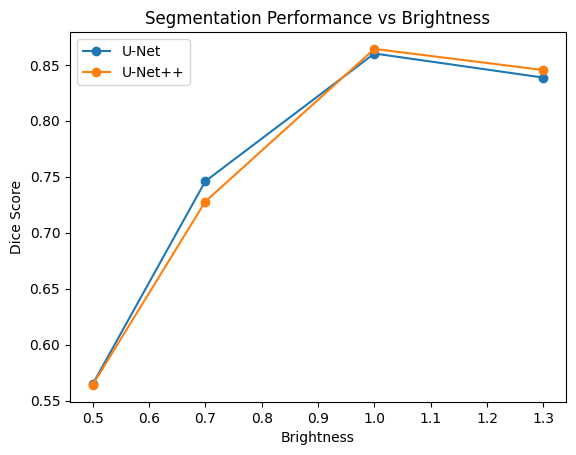

In [ ]:
# 3. (Optional but Good) Plot Comparison

import matplotlib.pyplot as plt

unet_dice = [unet_results[b][0] for b in brightness_levels]
unetpp_dice = [unetpp_results[b][0] for b in brightness_levels]

plt.plot(brightness_levels, unet_dice, marker='o', label="U-Net")
plt.plot(brightness_levels, unetpp_dice, marker='o', label="U-Net++")

plt.xlabel("Brightness")
plt.ylabel("Dice Score")
plt.title("Segmentation Performance vs Brightness")
plt.legend()
plt.show()


In [ ]:
os.makedirs("seg_results_unet", exist_ok=True)
os.makedirs("seg_results_unetpp", exist_ok=True)


In [ ]:
def save_overlays(model, dataset, save_dir, n=4):
    model.eval()

    for i in range(n):
        img, mask = dataset[i]

        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred = (pred > 0.5).float().cpu()

        img_np = img.permute(1,2,0).numpy()
        mask_np = mask.squeeze().numpy()
        pred_np = pred.squeeze().numpy()

        # Create overlay (red lesion)
        overlay = img_np.copy()
        overlay[pred_np == 1] = [1, 0, 0]

        plt.figure(figsize=(9,3))

        plt.subplot(1,3,1)
        plt.imshow(img_np)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(overlay)
        plt.title("Prediction")
        plt.axis('off')

        plt.savefig(f"{save_dir}/result_{i}.png", bbox_inches='tight')
        plt.close()

    print(f"Saved {n} images to {save_dir}")


In [ ]:
dataset_val = SegDataset(val_imgs, val_masks)

# U-Net
save_overlays(unet, dataset_val, "seg_results_unet", n=4)

# U-Net++
save_overlays(unetpp, dataset_val, "seg_results_unetpp", n=4)


Saved 4 images to seg_results_unet
Saved 4 images to seg_results_unetpp
